# Question Generation For Retrieval Evaluation
MLflow provides an advanced framework for constructing Retrieval-Augmented Generation (RAG) models.
RAG is a cutting edge approach that combines the strengths of retrieval models (a model that chooses and ranks relevant 
chunks of a document based on the user's question) and generative models.
It effectively merges the capabilities of searching and generating text to provide responses that are contextually
relevant and coherent, allowing the generated text to make reference to existing documents. RAG leverges the retriever to find context documents, and
this novel approach has revolutionized various NLP tasks.

Naturally, we want to be able to evaluate this retriever system for the RAG model to compare and judge its
performance. To evaluate a retriever system, we would first need a test set of questions on the documents.
These questions need to be diverse, relevant, and coherent. Manually generating questions may be challenging
because it first requires you to understand the documents, and spend lots of time coming up with questions 
for them. 

We want to make this process simpler by utilizing an LLM to generate questions for this test set. This
tutorial will walk through how to generate the questions and how to analyze the diversity and relevance
of the questions.

## Step 1: Install and Load Packages

In [0]:
import os
import pickle
from langchain.docstore.document import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain.docstore.document import Document
import openai

# For scraping
import requests
import urllib
import pandas as pd
from bs4 import BeautifulSoup

# For data analysis and visualization
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import pandas as pd
import numpy as np
import random

## Step 2: Set OpenAI Key
The question generation system can be done using any LLM. We chose to use OpenAI here, so we will need their API key.

In [0]:
openai.api_key = "<redacted>"
os.environ["OPENAI_API_KEY"] = "<redacted>"

## Step 3: Decide on chunk size and number of questions per chunk

In [0]:
CHUNK_SIZE = 1500
QUESTIONS_PER_CHUNK = 5
NUM_DOCUMENTS = 40  # Number of scraped chunks to use

## Step 4: Get Document Data
We scrape the documents from the Mlflow website to use to generate questions.

In [0]:
page = requests.get("https://mlflow.org/docs/latest/index.html")
soup = BeautifulSoup(page.content, 'html.parser')

mainLocation = "https://mlflow.org/docs/latest/"
header = {
    'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
    'Accept-Language': 'en-US,en;q=0.8',
    'Connection': 'keep-alive'
}

data = []
for a_link in soup.find_all('a'):
    document_url = mainLocation + a_link["href"]
    print('Getting file: {}'.format(document_url))
    page = requests.get(document_url, headers=header)
    soup = BeautifulSoup(page.content, 'html.parser')
    file_to_store = a_link.get('href').split('/')[-1]
    if soup.find("div", {"class": "rst-content"}):
        data.append([file_to_store, soup.find("div", {"class": "rst-content"}).text.replace('\n', ' ')])
      
df = pd.DataFrame(data, columns=['source', 'text'])
df.head(3)

Getting file: https://mlflow.org/docs/latest/#
/databricks/python/lib/python3.8/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
 warnings.warn(
Getting file: https://mlflow.org/docs/latest/#
Getting file: https://mlflow.org/docs/latest/what-is-mlflow.html
Getting file: https://mlflow.org/docs/latest/quickstart.html
Getting file: https://mlflow.org/docs/latest/quickstart_mlops.html
Getting file: https://mlflow.org/docs/latest/tutorials-and-examples/index.html
Getting file: https://mlflow.org/docs/latest/concepts.html
Getting file: https://mlflow.org/docs/latest/tracking.html
Getting file: https://mlflow.org/docs/latest/llm-tracking.html
Getting file: https://mlflow.org/docs/latest/projects.html
Getting file: https://mlflow.org/docs/latest/models.html
Getting file: https://mlflow.org/docs/latest/model-registry.html
Getting file: https://mlflow.org/docs/latest/recipes.html
Getting file: https://mlflow.org/docs/latest/gateway/index.html
Getting file: https://mlflow.org/docs/latest/llms/prompt-engineering.html
Getting file: https://mlflow.org/docs/latest/plugins.html
Getting file: https://mlflow.org/docs/latest/auth/index.html
Getting file: https://mlflow.org/docs/latest/cli.html
Getting file: https://mlflow.org/docs/latest/search-runs.html
Getting file: https://mlflow.org/docs/latest/search-experiments.html
Getting file: https://mlflow.org/docs/latest/python_api/index.html
Getting file: https://mlflow.org/docs/latest/R-api.html
Getting file: https://mlflow.org/docs/latest/java_api/index.html
Getting file: https://mlflow.org/docs/latest/rest-api.html
Getting file: https://mlflow.org/docs/latest/docker.html
Getting file: https://mlflow.org/docs/latest/community-model-flavors.html
Getting file: https://mlflow.org/docs/latest/https://github.com/mlflow/mlflow/blob/master/CONTRIBUTING.md
Getting file: https://mlflow.org/docs/latest/#
Getting file: https://mlflow.org/docs/latest/#mlflow-documentation
Getting file: https://mlflow.org/docs/latest/tracking.html#tracking
Getting file: https://mlflow.org/docs/latest/projects.html#projects
Getting file: https://mlflow.org/docs/latest/models.html#models
Getting file: https://mlflow.org/docs/latest/model-registry.html#registry
Getting file: https://mlflow.org/docs/latest/rest-api.html#rest-api
Getting file: https://mlflow.org/docs/latest/cli.html#cli
Getting file: https://mlflow.org/docs/latest/python_api/index.html#python-api
Getting file: https://mlflow.org/docs/latest/R-api.html#r-api
Getting file: https://mlflow.org/docs/latest/java_api/index.html#java-api
Getting file: https://mlflow.org/docs/latest/quickstart.html#quickstart
Getting file: https://mlflow.org/docs/latest/concepts.html#concepts
Getting file: https://mlflow.org/docs/latest/what-is-mlflow.html
Getting file: https://mlflow.org/docs/latest/quickstart.html
Getting file: https://mlflow.org/docs/latest/quickstart_mlops.html
Getting file: https://mlflow.org/docs/latest/tutorials-and-examples/index.html
Getting file: https://mlflow.org/docs/latest/concepts.html
Getting file: https://mlflow.org/docs/latest/tracking.html
Getting file: https://mlflow.org/docs/latest/llm-tracking.html
Getting file: https://mlflow.org/docs/latest/projects.html
Getting file: https://mlflow.org/docs/latest/models.html
Getting file: https://mlflow.org/docs/latest/model-registry.html
Getting file: https://mlflow.org/docs/latest/recipes.html
Getting file: https://mlflow.org/docs/latest/gateway/index.html
Getting file: https://mlflow.org/docs/latest/llms/prompt-engineering.html
Getting file: https://mlflow.org/docs/latest/plugins.html
Getting file: ht

,source,text
0,what-is-mlflow.html,Documentation What is MLflow? What i...
1,quickstart.html,"Documentation Quickstart: Install MLflow, ..."
2,quickstart_mlops.html,"Documentation Quickstart: Compare runs, ch..."


## Step 5: Load Document Data
We want to generate questions based on a set of documents. Here, we load the documents as Langchain Documents and utilize their embedding models. Through Langchain Documents, each document is broken down into a "chunk", which is a snippet of the text.

In [0]:
text_splitter = CharacterTextSplitter(chunk_size=CHUNK_SIZE, separator=" ")
documents = []
for index, page in df.iterrows():
    chunks = text_splitter.split_text(page[1])
    for chunk in chunks:
      documents.append(Document(page_content=chunk))
print(documents[0])

page_content='Documentation What is MLflow? What is MLflow? MLflow is a versatile, expandable, open-source platform for managing workflows and artifacts across the machine learning lifecycle. It has built-in integrations with many popular ML libraries, but can be used with any library, algorithm, or deployment tool. It is designed to be extensible, so you can write plugins to support new workflows, libraries, and tools. MLflow has five components: MLflow Tracking: An API for logging parameters, code versions, metrics, model environment dependencies, and model artifacts when running your machine learning code. MLflow Tracking has a UI for reviewing and comparing runs and their results. This image from the MLflow Tracking UI shows a chart linking metrics (learning rate and momentum) to a loss metric: MLflow Models: A model packaging format and suite of tools that let you easily deploy a trained model (from any ML library) for batch or real-time inference on platforms such as Docker, Apache Spark, Databricks, Azure ML and AWS SageMaker. This image shows MLflow Tracking UI’s view of a run’s detail and its MLflow model. You can see that the artifacts in the model directory include the model weights, files describing the model’s environment and dependencies, and sample code for loading the model and inferencing with it: MLflow Model Registry: A centralized model store, set of APIs, and UI focused on the approval, quality assurance, and deployment of an MLflow Model.' metadata={}

## Step 6: Generate Questions
The goal here is to generate questions that are coherant and contextually relevant to their respective document chunk. You can use any LLM, but in this tutorial we chose to generate the list of questions with OpenAI GPT3.5. We also utilize prompt engineering to produce better quality questions, as we found it to be a simple and effective way to improve the responses. In particular, we found two changes to be helpful:
- Better quality questions were produced if you ask the model for multiple questions per chunk rather than just one. This may be because it can ensure local diversity, better formatting, and have an implicit understanding that you are trying to get a list of questions.
- We observed that some questions reference the document without explaining what it is referencing, hence we include this in the prompt explicitly to help with this.

In [0]:
queries = []
for doc in documents[:NUM_DOCUMENTS]:
    chunk = doc.page_content
    chunks.append(chunk)
    params = {
        "model": "gpt-3.5-turbo",
        "messages": [
            {
                "role": "user",
                "content": f"{chunk}.\n Please generate {QUESTIONS_PER_CHUNK} questions based on the above document. The questions should be diverse and ask for different aspects of the document. Don't give vague references to the document without description. Split each question with a newline"
            }
        ],
    }

    response = openai.ChatCompletion.create(**params)
    response_queries = response.choices[0].message.content

    question_list = []
    for q in response_queries.splitlines():
      q = " ".join(q.split()[1:])
      print("\nQuestion:", q)
      question_list.append(q)

    queries.append({"chunk": chunk, "questions": question_list})

Question: How does MLflow enable users to manage workflows and artifacts across the machine learning lifecycle?

Question: Can MLflow be used with any machine learning library, algorithm, or deployment tool?

Question: What are the components of MLflow and what functionality does each component provide?

Question: How does MLflow Tracking help in monitoring and comparing runs of machine learning code?

Question: What features does MLflow Models offer for deploying trained models on different platforms such as Docker, Apache Spark, Databricks, Azure ML, and AWS SageMaker?

Question: What are the main components of MLflow and their respective purposes?

Question: How does MLflow help in managing the machine learning lifecycle?

Question: Who are the primary users of MLflow and how do they benefit from its features?

Question: Can you explain the role of MLflow Projects and how they enable reusable and reproducible ML code?

Question: How does MLflow Model Registry facilitate collaborative management of models and what functionalities does it provide?

Question: How do data scientists use MLflow to track experiments and select models for deployment?

Question: What are some use cases of MLflow in machine learning?

Question: How does MLflow benefit MLOps professionals in deploying and monitoring models in production?

Question: How can a team of data scientists utilize MLflow Tracking and the MLflow UI in their experimentation process?

Question: In what way can a data scientist structure their code with MLflow to facilitate collaboration and parameter adjustments?

Question: What is the main goal of using MLflow in a project?

Question: How does MLflow enable easy sharing of projects with others?

Question: Can MLflow handle running projects with different parameters?

Question: How long does it take to get started with MLflow?

Question: Who holds the rights to the MLflow Project?

Question: What are the main steps involved in the MLflow Quickstart?

Question: What is the purpose of MLflow Tracking for data scientists?

Question: What programming languages is MLflow available for?

Question: How can MLflow be installed using pip?

Question: How can MLflow automatically log the parameters, metrics, and artifacts of a run using popular ML libraries?

Question: How does autologging work in MLflow and what information does it automatically log during a run?

Question: Can you provide an example of autologging a scikit-learn run using MLflow?

Question: What are some key functions provided by MLflow for tracking parameters, metrics, and artifacts manually?

Question: In the example code provided, how are the models created and trained using scikit-learn?

Question: What can be considered as artifacts in a machine learning run, and how can they be logged using MLflow?

Question: What is the purpose of logging a parameter using the `log_param` function?

Question: How can you log a dictionary of parameters using the MLflow logging API?

Question: Can you provide an example of how to log a metric using the `log_metric` function, and explain why metrics can be updated throughout the run?

Question: How can you log an artifact (output file) in MLflow, and what would be an example of creating and logging an artifact file?

Question: How can you disable autologging in MLflow if you are using a supporting library?

Question: What information is displayed in the Table view of the MLflow UI?

Question: How can you view the details of a specific run in the MLflow UI?

Question: How can you track the history of a specific metric in MLflow?

Question: What is the purpose of the Chart view in the MLflow UI?

Question: How can you store MLflow tracking data and artifacts remotely instead of locally?

Question: How can you configure MLflow to use a tracking server?

Question: What is the purpose of setting the MLFLOW_TRACKING_URI environment variable?

Question: How can you add tracking data to a running tracking server using mlflow.set_tracking_ur

## Quality Analysis of Questions Generated (Optional)
If you would like to compare quality of questions generated across different prompts, we can
analyze the quality of questions manually and in aggregate. We want to evaluate questions 
along two dimensions - their diversity and relevance.

Note: There isn't a well-defined way to analyze the quality of generated questions, so this is just one approach you can take to gain insight into how diverse and relevant your generated questions are.

### Evaluating Diversity of Questions

Diversity of questions is important because we want questions to cover the majority of the
document content. In addition, we want to be able to evaluate the retriever with different 
forms of questioning. We want to be able to have harder questions and easier questions. All
of these are not straightforward to analyze, and we decided to analyze its through question
length and latent space embeddings.

In [0]:
# Get all the questions in a list
questions = []
for query in queries:
  questions += query["questions"]

#### Length
Length gives a sense of how diverse the questions are. Some questions may be wordy while
others are straight to the point. It also allows us to identify problems with the question
generated. For example, you may identify some questions to have a length of 0.

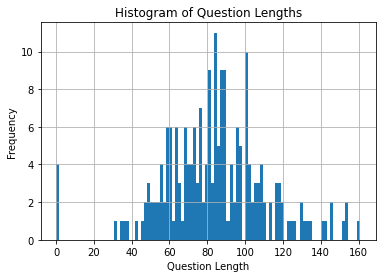

In [0]:
# Length
question_len = pd.DataFrame([len(q) for q in questions], columns=["length"])
question_len.hist(bins=100)
plt.title("Histogram of Question Lengths")
plt.xlabel("Question Length")
plt.ylabel("Frequency")
plt.show()

In addition to visual representation, we also want to look at more concrete percentile values.


In [0]:
#Calculating percentile values
p10 = int(question_len["length"].quantile(0.10))
p90 = int(question_len["length"].quantile(0.90))
print("p10-p90 range is", p90-p10)

p10-p90 range is 63

We noticed that the short queries are all empty strings, and hence we need to filter for this.

In [0]:
[q for q in questions if len(q) < 5]

Out[20]: ['', '', '', '']

There are also a couple queries that are longer than normal. However, these seem fine.

In [0]:
[q for q in questions if len(q) > 160]

Out[21]: ['What features does MLflow Models offer for deploying trained models on different platforms such as Docker, Apache Spark, Databricks, Azure ML, and AWS SageMaker?']

#### Latent Space
Latent space embeddings contain semantic information about the question. This can be used to 
evaluate the diversity and the difference between two questions semantically. To do so, we will need to map the
high dimensional space to a lower dimensional space. We utilize PCA and TSNE to map the embeddings 
into a 2-dimensional space for visualization.

In [0]:
# post process to remove empty questions
questions_to_embed = [q for q in questions if len(q) > 0]

We append 5 benchmark queries to help visualize how diverse the questions are. The first four of these questions are semantically similar and all asking about Mlflow, while the last is different and refers to spark and model registry.

In [0]:
benchmark_questions = ["What is MLflow?", "What is Mlflow about?", "Tell me about Mlflow Tracking.", "What are the benefits of using Mlflow?", "How can I use spark in model registry?"]
questions_to_embed = questions_to_embed + benchmark_questions

We apply PCA to reduce the embedding dimensions to 50 before applying TSNE to reduce it to 2 dimensions, as recommended by sklearn due to the computational complexity of TSNE.

In [0]:
# Apply embeddings
embeddings = OpenAIEmbeddings()
question_embeddings = embeddings.embed_documents(questions_to_embed)
# PCA on embeddings to reduce to 50-dim
pca = sklearn.decomposition.PCA(n_components=50)
question_embeddings_50 = pca.fit_transform(question_embeddings)
# TSNE on embeddings to reduce to 2-dim
tsne = sklearn.manifold.TSNE(n_components=2)
lower_dim_embeddings = tsne.fit_transform(question_embeddings_50)

Now that we have 2-dimensional embeddings representing the semantics of the question, we can visualize it with a scatter plot, differentiating the generated questions and the benchmark questions.

Out[25]:

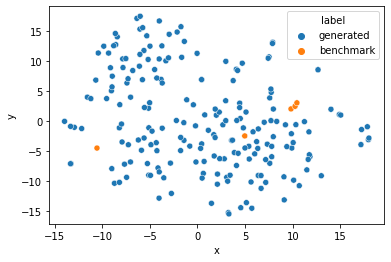

<AxesSubplot:xlabel='x', ylabel='y'>

In [0]:
labels = np.concatenate([
  np.full(len(lower_dim_embeddings)-len(benchmark_questions), "generated"), 
  np.full(len(benchmark_questions), "benchmark")
])
data = pd.DataFrame(
  {
    "x": lower_dim_embeddings[:,0],
    "y": lower_dim_embeddings[:,1],
    "label": labels
  }
)
sns.scatterplot(data=data, x="x", y="y", hue="label")

Observe that within the orange points on the scatter plot, there is one point that is further than the others. That is the different benchmark question about Spark and Model Registry. This plot gives a sense of the diversity of the questions generated.

### Evaluate Document Relevance
Another important axis to consider is how relevant the questions are to the document we provided. We want to understand whether the questions generated by the LLM is actually referring to our provided text, or whether it is hallucinating irrelevant questions. We will evaluate relevance by first manually checking certain questions against their document chunk. Then, we define a measure of relevance to analyze it quantitatively.

#### Manual Checking of Document Relevance

Manual qualitative check of whether the questions are relevant to the document.

In [0]:
samples = 10 # num of chunks we want to observe

for query in random.sample(queries, samples):
  print("Chunk:", query["chunk"])
  for q in query["questions"]:
    print("Question:", q)
  print('-'*80) # delimiter

Chunk: whether you are a data scientist working alone or part of a large organization: Individual Data Scientists can use MLflow Tracking to track experiments locally on their machine, organize code in projects for future reuse, and output models that production engineers can then deploy using MLflow’s deployment tools. MLflow Tracking just reads and writes files to the local file system by default, so there is no need to deploy a server. Data Science Teams can deploy an MLflow Tracking server to log and compare results across multiple users working on the same problem. By setting up a convention for naming their parameters and metrics, they can try different algorithms to tackle the same problem and then run the same algorithms again on new data to compare models in the future. Moreover, anyone can download and run another model. Large Organizations can share projects, models, and results using MLflow. Any team can run another team’s code using MLflow Projects, so organizations can package useful training and data preparation steps that other teams can use, or compare results from many teams on the same task. Moreover, engineering teams can easily move workflows from R&D to staging to production. Production Engineers can deploy models from diverse ML libraries in the same way, store the models as files in a management system of their choice, and track which run a model came from. Researchers and Open Source Developers can publish code to GitHub in the MLflow Project format, making
Question: How can individual data scientists use MLflow Tracking to effectively organize their code and output models?
Question: What is the purpose of deploying an MLflow Tracking server for data science teams? How does it enable collaboration and comparison of results?
Question: In what ways can large organizations benefit from using MLflow in terms of sharing projects, models, and results?
Question: How does MLflow enable production engineers to deploy models from different ML libraries and track their origins?
Question: What opportunities does MLflow provide for researchers and open-source developers to publish their code and projects?
----------------------------------------------------------------------------------------------------
Chunk: project URI and source version. You can optionally organize runs into experiments, which group together runs for a specific task. You can create an experiment using the mlflow experiments CLI, with mlflow.create_experiment(), or using the corresponding REST parameters. The MLflow API and UI let you create and search for experiments. Once your runs have been recorded, you can query them using the Tracking UI or the MLflow API. Where Runs Are Recorded MLflow runs can be recorded to local files, to a SQLAlchemy-compatible database, or remotely to a tracking server. By default, the MLflow Python API logs runs locally to files in an mlruns directory wherever you ran your program. You can then run mlflow ui to see the logged runs. To log runs remotely, set the MLFLOW_TRACKING_URI environment variable to a tracking server’s URI or call mlflow.set_tracking_uri(). There are different kinds of remote tracking URIs: Local file path (specified as file:/my/local/dir), where data is just directly stored locally. Database encoded as <dialect>+<driver>://<username>:<password>@<host>:<port>/<database>. MLflow supports the dialects mysql, mssql, sqlite, and postgresql. For more details, see SQLAlchemy database uri. HTTP server (specified as https://my-server:5000), which is a server hosting an MLflow tracking server. Databricks workspace (specified as databricks or as databricks://<profileName>, a Databricks CLI profile. Refer to Access the MLflow tracking server from outside Databricks
Question: What are the different options for recording MLflow runs?
Question: How can you create and search for experiments using MLflow?
Question: How are runs logged locally by default using the MLflow Python API?
Question: What is the purpo

#### Embeddings Cosine Similarity

The embedding of the chunk and query is placed in the same latent space, and the retriever model would extract similar chunk embeddings to a query embedding. Hence, relevance for the retriever is defined by the distance of embeddings in this latent space.

Cosine similarity is a measure of vector similarity, and can be used to determine the distance of embeddings between the chunk and the query. It is a distance metric that approaches 1 when the question and chunk are similar, and becomes 0 when they are different.

We can use the cosine similarity score directly to measure the relevancy. However, if we just have a cosine similarity score, it is not interpretable without something to compare it to. Hence, we define relative question relevance as:
$$\frac{cossim(chunk, question_q)}{\frac{1}{len(questions)-1}\sum_{i\ !=\ q}cossim(chunk, question_i)}$$
where `question_q` is a question generated from the chunk.

This relative question relevance can measure how much more relevant a question generated from the chunk is compared to a question generated by another chunk in this dataset. It would give a score of above 1 if the question generated from the chunk is more relevant and a score below if its not. We can then use this score to identify any irrelevant questions generated.

In [0]:
embedded_queries = []
for query in queries:
  embedded_query = {
    "chunk": np.squeeze(embeddings.embed_documents([query["chunk"]])),
    "questions": embeddings.embed_documents([q for q in query["questions"] if len(q) > 0]) # embedding cant take empty strings
  }
  embedded_queries.append(embedded_query)

In [0]:
def cossim(x, y):
  return np.dot(x,y)/(np.linalg.norm(x) * np.linalg.norm(y))

question_relevance = []
for i, query in enumerate(embedded_queries):
  for q_index, question_emb in enumerate(query["questions"]):
    # generate cosine similarity for the chunk the question is generated from
    chunk_sim = cossim(question_emb, query["chunk"])

    # generate average cosine similarity between chunk and irrelevant questions
    avg_irrelevant_cossim = []
    for j, other_query in enumerate(embedded_queries):
      if i != j:
        # supposedly irrelevant questions to the chunk.
        for q_emb in other_query["questions"]:
          avg_irrelevant_cossim.append(cossim(q_emb, query["chunk"]))
    other_sim = np.average(avg_irrelevant_cossim)
    question_relevance.append({
      "question": queries[i]["questions"][q_index], # text version of question
      "chunk": queries[i]["chunk"], # text version of chunk
      "score": chunk_sim / other_sim # relative similarity score
    })

After we score each question by its relative relevancy, we can evaluate the generated questions as a whole.

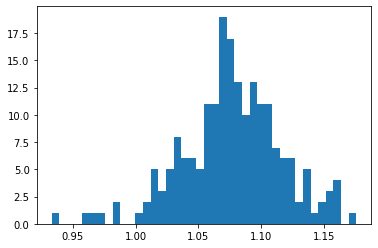

In [0]:
# score above 1 means it is more relevant to its chunk than other chunks in the document (relative relevance). This shows that most chunks are relatively relevant.
scores = [x["score"] for x in question_relevance]
plt.hist(scores, bins=40);

There are a couple scores that are less than 1, lets take a look at those.

In [0]:
for question_evaluation in [x for x in question_relevance if x["score"] < 1]:
  print(question_evaluation["chunk"])
  print(question_evaluation["question"], question_evaluation["score"])
  print("-"*80) # delimiter

to configure your experiment: databricks configure Set the Databricks Host to the URL of your Databricks workspace, and set the Username and Password to the credentials you use to access the workspace. If you’ve created an authentication token for your Databricks workspace (databricks tokens create), you can use it instead of your password. Call databricks configure with the -t, \--token option. In your training code, modify the call to mlflow.set_tracking_uri to use Databricks and set the experiment to the path of your experiment in Databricks, replacing user_name and experiment_name with the appropriate values: mlflow.set_tracking_uri("databricks") mlflow.set_experiment(f"/Users/{user_name}/{experiment_name}") If the specified experiment does not exist, it will be created. For more on using MLflow with Databricks, see Databricks’ documentation on MLflow. Store a model in MLflow An MLflow Model is a directory that packages machine learning models and support files in a standard format. The directory contains: An MLModel file in YAML format specifying the model’s flavor (or flavors), dependencies, signature (if supplied), and important metadata; The various files required by the model’s flavor(s) to instantiate the model. This will often be a serialized Python object; Files necessary for recreating the model’s runtime environment (for instance, a conda.yaml file); and Optionally, an input example When using autologging, MLflow will automatically log whatever
What files and components are included in an MLflow Model directory? 0.9864721739527278
--------------------------------------------------------------------------------
Files necessary for recreating the model’s runtime environment (for instance, a conda.yaml file); and Optionally, an input example When using autologging, MLflow will automatically log whatever model or models the run creates. You can also log a model manually by calling mlflow.{library_module_name}.log_model. In addition, if you wish to load the model soon, it may be convenient to output the run’s ID directly to the console. For that, you’ll need the object of type mlflow.ActiveRun for the current run. You get that object by wrapping all of your logging code in a with mlflow.start_run() as run: block. (mlflow.start_run() API reference) For example: For example: import mlflow from mlflow.models import infer_signature from sklearn.model_selection import train_test_split from sklearn.datasets import load_diabetes from sklearn.ensemble import RandomForestRegressor with mlflow.start_run() as run: # Load the diabetes dataset. db = load_diabetes() X_train, X_test, y_train, y_test = train_test_split(db.data, db.target) # Create and train models. rf = RandomForestRegressor(n_estimators=100, max_depth=6, max_features=3) rf.fit(X_train, y_train) # Use the model to make predictions on the test dataset. predictions = rf.predict(X_test) print(predictions) signature = infer_signature(X_test, predictions) mlflow.sklearn.log_model(rf, "model", signature=signature) print(f"Run ID: {run.info.run_id}") In the case of the sklearn flavor,
Can you explain the purpose of the infer_signature function in the provided example? 0.9332239845529254
--------------------------------------------------------------------------------
signature = infer_signature(X_test, predictions) mlflow.sklearn.log_model(rf, "model", signature=signature) print(f"Run ID: {run.info.run_id}") In the case of the sklearn flavor, log_model stores the following files in the artifacts directory of the run’s directory on the tracking server: model/ |-- MLmodel |-- conda.yaml |-- model.pkl |-- python_env.yaml |-- requirements.txt If you’ve not called set_tracking_uri or set the MLFLOW_TRACKING_URI environment variable to point to a remote tracking server, this model directory will be under the mlruns directory. For more information, including a list of supported model flavors and storing your own flavor, see Built-In Model Flavors. Load a model from a specific train

Manual verification of these "irrelevant" questions demonstrate that they do refer to the chunk but are vague or doesn't align with the main focus. Hence, we can choose to filter these as desired.